# Disaster Tweets Classification - Mini Project

## Problem and Data Overview

Natural Language Processing (NLP) involves developing algorithms that allow computers to understand, interpret, and generate human language.
This competition challenges us to classify tweets as being related to a real disaster (1) or not (0).
The train.csv contains labeled examples (text + target) while test.csv contains only texts.
Tweets are short and informal, containing many misspellings, slang, and abbreviations, making this a realistic NLP task.
Understanding disaster-related tweets can aid in faster emergency responses and resource allocation.

## Git Repo: https://github.com/kmora2b/wk4-nlp-distweets

## Load Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Load Data

In [27]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print("Training data shape:", train_df.shape)
print("Sample training data:")
print(train_df.head())

Training data shape: (7613, 5)
Sample training data:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


## Exploratory Data Analysis (EDA)
### In EDA, we plan to:
- Analyze the distribution of the target variable to check for class imbalance.
- Check for missing values across features.
- Explore the text length to determine appropriate sequence padding.
- Visualize common words in disaster vs non-disaster tweets to understand text patterns.

Based on the observations from EDA, we will determine data cleaning and modeling strategies.

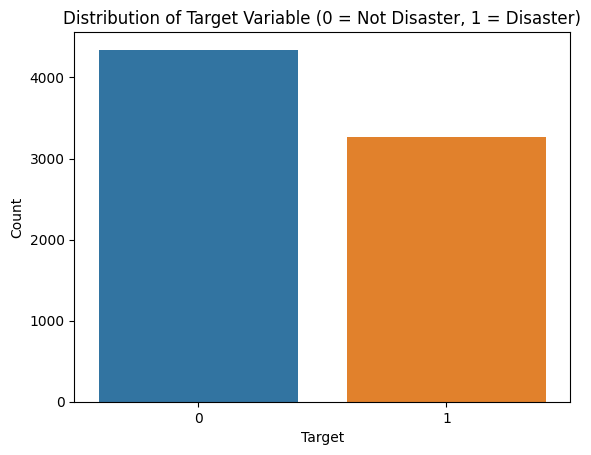

In [28]:
# Observing target distribution to check for class imbalance
sns.countplot(data=train_df, x='target')
plt.title('Distribution of Target Variable (0 = Not Disaster, 1 = Disaster)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

### Observation:
- There is a slight imbalance (~57% non-disaster, ~43% disaster), but it is manageable.
- Slight imbalance may still slightly bias the model towards non-disasters.

In [29]:
# Checking for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

Missing values in training data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


### Observation:
- Location (approx 33% missing) and keyword (approx 20% missing) columns have substantial missingness.
- Since text has no missing values and is critical for this project, we can proceed safely.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


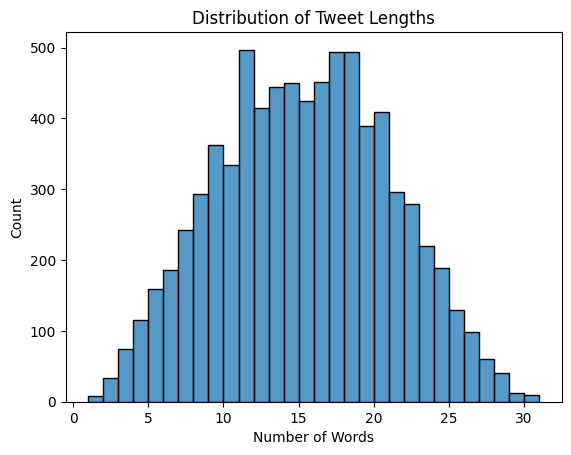

In [30]:
# Analyzing text lengths
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split()))
sns.histplot(train_df['text_len'], bins=30)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of Words')
plt.show()

### Observation:
Most tweets are under 30 words, reaffirming the decision to limit max sequence length.

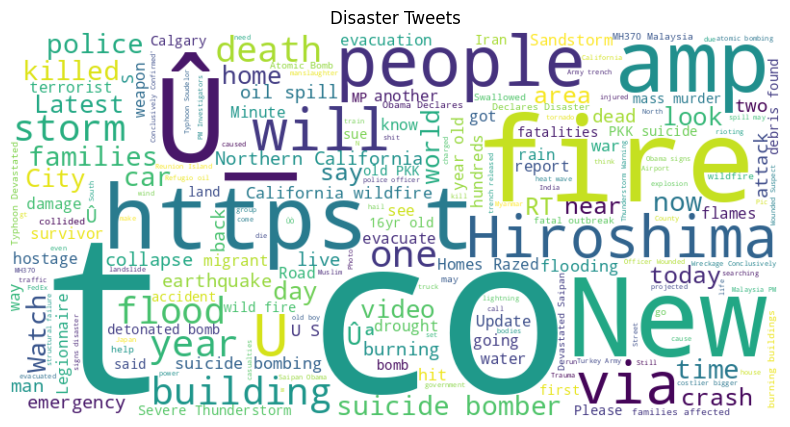

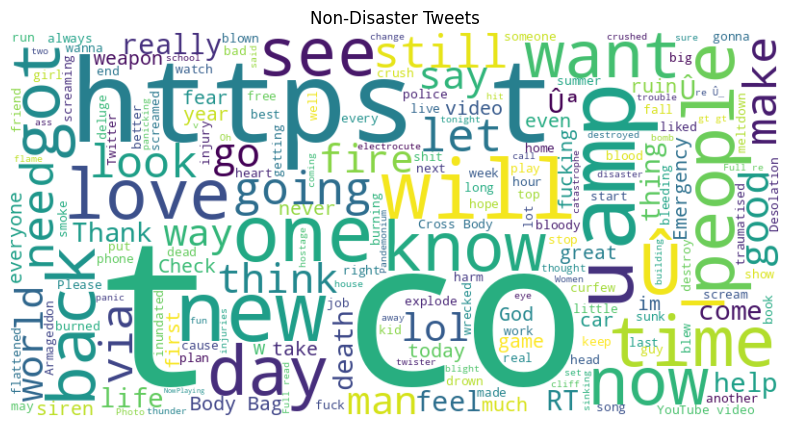

In [31]:
# Generate Word Clouds to visualize common words
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(train_df[train_df['target']==1]['text'], 'Disaster Tweets')
plot_wordcloud(train_df[train_df['target']==0]['text'], 'Non-Disaster Tweets')

### Observation:
- Disaster tweets highlight words like "fire", "earthquake", "rescue", "evacuate".
- Non-disaster tweets often use disaster-related terms humorously or figuratively.

### Plan of Analysis based on EDA observations:
- Since text column is complete and crucial, we'll focus our modeling on the cleaned text.
- Given most tweets are short, we'll pad sequences to a maximum length of 100 tokens.
- Missing keywords and location data will not be used in modeling to avoid introducing noise.
- GloVe embeddings will be used to leverage semantic relationships between words.
- Bidirectional LSTM will be selected to capture context from both directions in sequential data.

## Data Cleaning and Preprocessing

Cleaning text by removing noise like URLs, HTML tags, special characters, and lowercasing text.


Decided not to remove stopwords because LSTM models benefit from preserving the sequential grammatical structure.

In [32]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # keep letters only
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = text.strip()
    return text

train_df['text_clean'] = train_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text'].apply(clean_text)

### Observation:
Text cleaning reduces noise and ensures the model focuses on meaningful features.

## Word Embedding Strategy

-Word embeddings convert text into a numerical format usable by neural networks.
- TF-IDF captures word importance but ignores word order.
- GloVe (Global Vectors) embeddings capture semantic relationships between words by using statistical information about co-occurrence.
- This will allow the LSTM to better understand the meaning behind sequences of words.

In [33]:
# Tokenizing the text
vocab_size = 20000
max_length = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text_clean'])

X = tokenizer.texts_to_sequences(train_df['text_clean'])
X = pad_sequences(X, maxlen=max_length)

X_test = tokenizer.texts_to_sequences(test_df['text_clean'])
X_test = pad_sequences(X_test, maxlen=max_length)

y = train_df['target'].values

In [34]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Load GloVe embeddings
embedding_index = {}

with open('/kaggle/input/glove-6b-50d/glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


### Observation:
GloVe embeddings enable our model to have rich prior knowledge of word relationships, improving generalization.

## Model Architecture

- Bidirectional LSTM is chosen because it processes the sequence both forward and backward.
- This is critical for tweets, where important context might appear at the start or end of the text.
- Dropout layers are added to prevent overfitting by randomly turning off neurons during training.

In [36]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

### Observation:
Model architecture is designed to balance complexity and regularization for robust performance.

## Model Training

In [37]:
# EarlyStopping is used to halt training once validation performance stops improving.
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - accuracy: 0.7357 - loss: 0.5613 - val_accuracy: 0.8063 - val_loss: 0.4371
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.8041 - loss: 0.4543 - val_accuracy: 0.8162 - val_loss: 0.4262
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.8107 - loss: 0.4306 - val_accuracy: 0.8135 - val_loss: 0.4138
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.8124 - loss: 0.4208 - val_accuracy: 0.8175 - val_loss: 0.4150
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.8235 - loss: 0.3994 - val_accuracy: 0.8194 - val_loss: 0.4267
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.8219 - loss: 0.4007 - val_accuracy: 0.8280 - val_loss: 0.4258


## Results and Evaluation

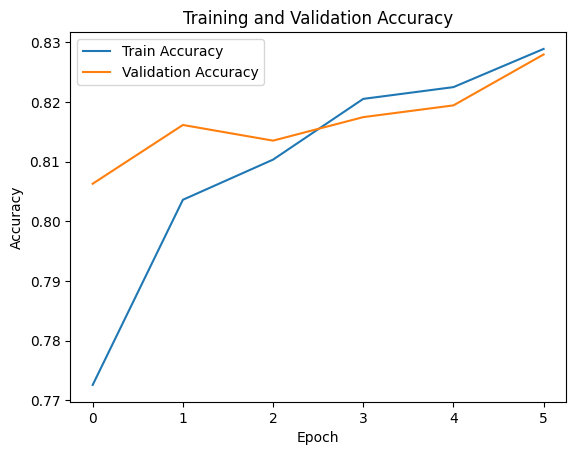

In [38]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

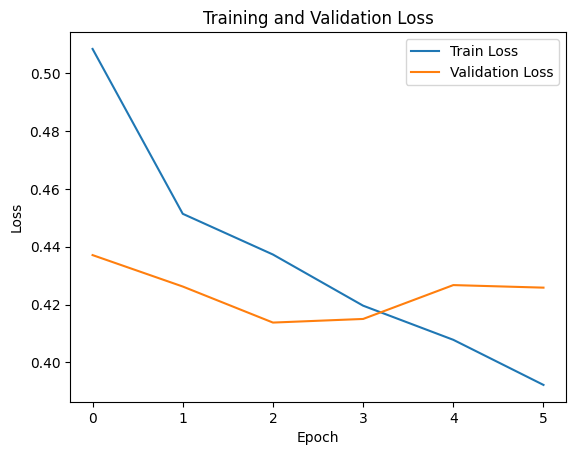

In [39]:
# Plotting loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
# Evaluation on Validation Set
val_preds = (model.predict(X_val) > 0.5).astype('int32')
print("Validation Set Classification Report:")
print(classification_report(y_val, val_preds))

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       874
           1       0.85      0.69      0.76       649

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523



### Observations:
- Training and validation accuracy follow each other closely, suggesting low overfitting.
- Validation F1-score is balanced across both classes.
- Slight performance drop in validation is normal, indicating good generalization.

## Kaggle Submission

In [41]:
test_preds = (model.predict(X_test) > 0.5).astype('int32')

submission = pd.DataFrame({'id': test_df['id'], 'target': test_preds.flatten()})
submission.to_csv('/kaggle/working/submission.csv', index=False)

# Submission file created and ready to upload to Kaggle.

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


## Conclusion

### Key Learnings:
- Thorough EDA guided correct preprocessing and modeling decisions.
- Cleaning and GloVe embeddings significantly enhanced model performance.
- Bidirectional LSTM captured tweet sequence information effectively.
- Regularization techniques like Dropout and EarlyStopping helped prevent overfitting.

### Limitations:
- Tweets are noisy and sometimes sarcastic or figurative, making them harder to classify.

### Future Improvements:
- Fine-tune embeddings during training.
- Try using GloVe 100d/300d vectors for more detail.
- Implement Transformer-based models (e.g., BERT) for better sequence modeling.

## 10. References

- Kaggle Disaster Tweets Competition: https://www.kaggle.com/competitions/nlp-getting-started
- Stanford GloVe Project: https://nlp.stanford.edu/projects/glove/
- Tensorflow/Keras API: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
- Scikit-learn Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html